<a href="https://colab.research.google.com/github/Tsahif/aiblog/blob/main/mlpfunc_blog.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
import torch.nn as nn
import imageio
import os

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


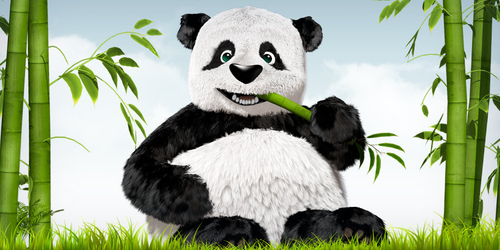

In [ ]:
im = Image.open('/content/gdrive/MyDrive/Colab Notebooks/panda.jpg')

basewidth = 500
wpercent = (basewidth/float(im.size[0]))
hsize = int((float(im.size[1])*float(wpercent)))
im = im.resize((basewidth,hsize), Image.LANCZOS)

im.show()

In [ ]:
min_dim = min(im.size)

In [ ]:
transform = transforms.Compose([transforms.ToTensor(), transforms.CenterCrop(min_dim)])

tensor = transform(im)

In [ ]:
tensor.shape

torch.Size([3, 250, 250])

In [ ]:
# randomly sample 10000 points from the image
n_samples = 25000

x_grid, y_grid = np.meshgrid(np.linspace(0,1, tensor.shape[2]), np.linspace(0,1, tensor.shape[1]))

In [ ]:
im_flat = tensor.reshape(3,-1)

In [ ]:
idx = np.random.choice(np.arange(0, im_flat.shape[1]), n_samples, replace = False)

test_idx = idx[int(0.8*idx.shape[0]):]
idx = idx[:int(0.8*idx.shape[0])]

In [ ]:
test_idx.shape

(5000,)

In [ ]:
labels = im_flat[:, idx].transpose(1,0)
test_labels = im_flat[:, test_idx].transpose(1,0)
raw_features = torch.Tensor([x_grid.reshape(-1)[idx], y_grid.reshape(-1)[idx]]).T
raw_test_features = torch.Tensor([x_grid.reshape(-1)[test_idx], y_grid.reshape(-1)[test_idx]]).T
# labels = tensor.permute(1,2,0)[::2,::2].reshape(-1,3)
# xy_features = torch.Tensor([x_grid[::2,::2].reshape(-1), y_grid[::2,::2].reshape(-1)]).T

In [ ]:
# check data creation was ok by creating an image with zeros and filling with samples points
test_im = torch.zeros([3, tensor.shape[1], tensor.shape[2]])

# r = 0.5*(raw_features[:,1] + 1) * (tensor.shape[1] - 1)
# c = 0.5*(raw_features[:,0] + 1) * (tensor.shape[2] - 1)


r = (raw_features[:,1]) * (tensor.shape[1] - 1)
c = (raw_features[:,0]) * (tensor.shape[2] - 1)

r = r.to(int)
c = c.to(int)


In [ ]:
test_im[:,r,c] = labels.T

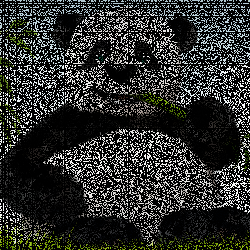

In [ ]:
transforms.ToPILImage()(test_im).show()

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
n_layers = 4
n_width = 256
mapping_size = 256


In [ ]:
def input_mapping(x, B):
  if B is None:
    return x
  else:
    x_proj = (2.*np.pi*x) @ B.T
    return np.concatenate([np.sin(x_proj), np.cos(x_proj)], axis=-1)

In [ ]:
# features = xy_features.to(device)
train_labels = labels.to(device)
test_labels = test_labels.to(device)

def create_train_test_features(scale):
  B = None
  if scale == 'basic':
    B = np.eye(2)
  elif scale is not None:
    B = np.random.normal(0, scale, (mapping_size, 2))
  features = torch.Tensor(input_mapping(raw_features.cpu(), B)).to(device)
  test_features_gpu = torch.Tensor(input_mapping(raw_test_features.cpu(), B)).to(device)
  full_features = torch.tensor(input_mapping(full_grid, B)).to(torch.float32).to(device)
  return features, test_features_gpu, full_features

In [ ]:
def create_model(features):
  model = nn.Sequential()
  model.add_module('m1',nn.Linear(features.shape[1], n_width))
  for i in range(n_layers):
    model.add_module(f'r{i}',nn.ReLU())
    model.add_module(f'l{i}',nn.Linear(n_width, n_width))
  model.add_module('f',nn.Linear(n_width, 3))
  model.add_module('s',nn.Sigmoid())

  model = model.to(device)
  return model

In [ ]:
device

device(type='cuda', index=0)

In [ ]:
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
loss_fn = nn.MSELoss()

In [ ]:
full_grid = torch.tensor([x_grid.reshape(-1), y_grid.reshape(-1)]).T.to(torch.float32)
# full_features = torch.tensor(input_mapping(full_grid, B)).to(torch.float32).to(device)

In [ ]:
def training_loop(model, train_samples, test_samples, full_features):

  num_epochs = 2000
  PATIENCE = 10
  best_loss = np.inf

  train_features, train_labels = train_samples
  test_features, test_labels = test_samples

  losses = []
  image_samples = []

  optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

  for n in range(num_epochs):
    print(n)
    model.train()
    y_pred = model(train_features)
    loss = loss_fn(y_pred, train_labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    model.eval()
    with torch.no_grad():
        y_test = model(test_features)
        test_loss = loss_fn(y_test, test_labels).cpu().numpy()
        if test_loss < best_loss:
          best_loss = test_loss
          patience = PATIENCE
        else:
          patience -= 1
          if patience == 0:
            break
        losses.append(test_loss)

        # generate prediction image every 20 iterations
        if n % 5 == 0:
          print('generating sample image')
          image_samples.append(model(full_features).to('cpu').reshape(min_dim, min_dim,-1))

  model.eval()
  with torch.no_grad():
    image_samples.append(model(full_features).to('cpu').reshape(min_dim, min_dim,-1))

  return image_samples, losses

In [ ]:
scales = {'No mapping':None, 'basic':'basic', 'gauss_2':2, 'gauss_5':5, 'gauss_10':10, 'gauss_20':20}

progression_images = {}
for s in scales:
  features = create_train_test_features(scales[s])
  train_features, test_features, full_features = features
  model = create_model(train_features)
  progression_images[s], _ = training_loop(model, (train_features, train_labels), (test_features, test_labels), full_features)


<ipython-input-94-28f81ac71225>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  full_features = torch.tensor(input_mapping(full_grid, B)).to(torch.float32).to(device)


0
generating sample image
1
2
3
4
5
generating sample image
6
7
8
9
10
generating sample image
11
12
13
14
15
generating sample image
16
17
18
19
20
generating sample image
21
22
23
24
25
generating sample image
26
27
28
29
30
generating sample image
31
32
33
34
35
generating sample image
36
37
38
39
40
generating sample image
41
42
43
44
45
generating sample image
46
47
48
49
50
generating sample image
51
52
53
54
55
generating sample image
56
57
58
59
60
generating sample image
61
62
63
64
65
generating sample image
66
67
68
69
70
generating sample image
71
72
73
74
75
generating sample image
76
77
78
79
80
generating sample image
81
82
83
84
85
generating sample image
86
87
88
89
90
generating sample image
91
92
93
94
95
generating sample image
96
97
98
99
100
generating sample image
101
102
103
104
105
generating sample image
106
107
108
109
110
generating sample image
111
112
113
114
115
generating sample image
116
117
118
119
120
generating sample image
121
122
123
124
125
genera

In [ ]:
comparison = torch.concatenate([progression_images[s][-1] for s in scales], axis = -2).permute(2,0,1)

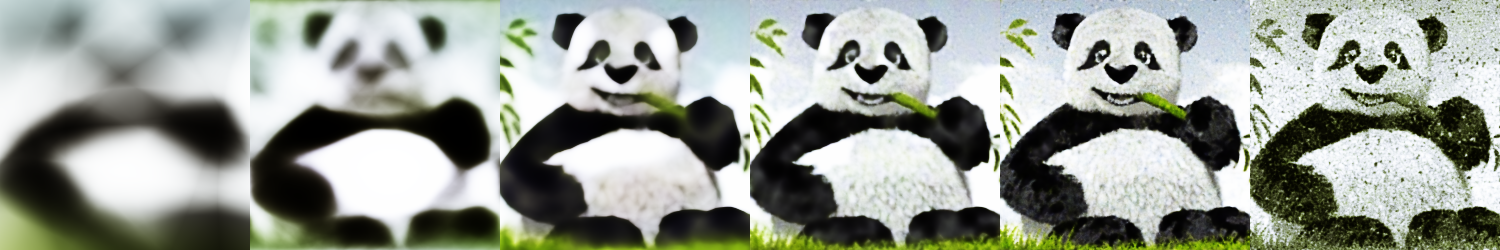

In [ ]:
transforms.ToPILImage()(comparison).show()

In [ ]:
fr, fc = np.meshgrid(range(0, tensor.shape[1]), range(0, tensor.shape[2]))

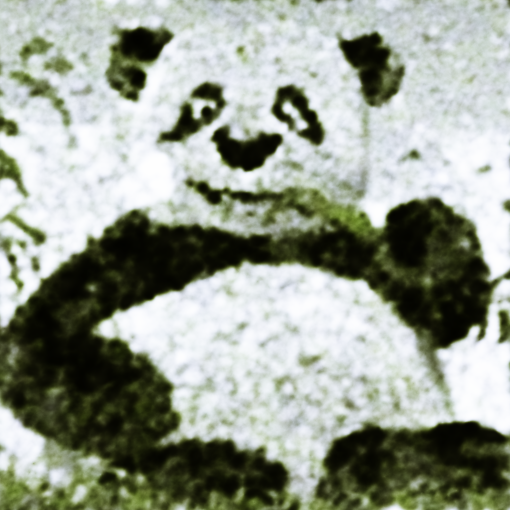

In [ ]:
full_grid = torch.tensor([x_grid.reshape(-1), y_grid.reshape(-1)]).T.to(torch.float32)
full_features = torch.tensor(input_mapping(full_grid, B)).to(torch.float32).to(device)
y_pred = model(full_features).to('cpu')
fc, fr = np.meshgrid(range(0, tensor.shape[2]), range(0, tensor.shape[1]))
fc = fc.reshape(-1)
fr = fr.reshape(-1)

test_im[:,fr,fc] = y_pred.T
transforms.ToPILImage()(test_im).show()

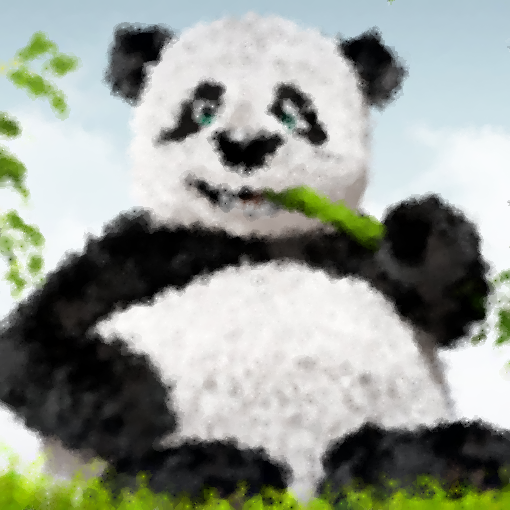

In [ ]:
from sklearn import neighbors
n_neighbors = 5

knn = neighbors.KNeighborsRegressor(n_neighbors, weights="distance")
y_pred = knn.fit(features.cpu(), labels.cpu()).predict(test_features.cpu())
y_pred = torch.Tensor(y_pred)
test_im[:,fr,fc] = y_pred.T
transforms.ToPILImage()(test_im).show()

\begin{align}
c = f(x,y) \\
y = \sum_i K(x,x_i) \cdot \cdot (K^{-1}\cdot y)_i
\end{align}

In [ ]:
a = np.array([[[1,2],[1,2]],[[3,4],[3,4]] ])

In [ ]:
a.shape

(2, 2, 2)

In [ ]:
np.pad(a,((0, 2),(0,0),(0,0)), mode='edge')

array([[[1, 2],
        [1, 2]],

       [[3, 4],
        [3, 4]],

       [[3, 4],
        [3, 4]],

       [[3, 4],
        [3, 4]]])

In [ ]:
max_num_imgs = max([len(progression_images[s]) for s in scales])

pad_lengths = [max_num_imgs - len(progression_images[s]) for s in scales]

stacked = [np.stack(progression_images[s]) for s in scales]




In [ ]:
stacked_adjusted = [np.pad(a,((0, max_num_imgs - a.shape[0]),(0,0),(0,0),(0,0)), mode='edge') for a in stacked]


In [ ]:
wide_movie = np.concatenate([m for m in stacked_adjusted], axis=-2)

In [ ]:
wide_movie.shape

(144, 250, 1500, 3)

In [ ]:
data8 = (255*np.clip(wide_movie, 0, 1)).astype(np.uint8)
f = os.path.join('training_convergence.mp4')
imageio.mimwrite(f, data8, fps=20)

# Display video inline
from IPython.display import HTML
from base64 import b64encode
mp4 = open(f, 'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()


In [ ]:
progression_images.keys()

dict_keys(['No mapping', 'basic', 'gauss_2', 'gauss_5', 'gauss_10', 'gauss_20'])

In [ ]:
n_cases = len(progression_images)
HTML(f'''
<video width=1500 controls autoplay loop>
      <source src="{data_url}" type="video/mp4">
</video>
<table width="1500" cellspacing="0" cellpadding="0">
  <tr>{''.join(n_cases*[f'<td width="{1500//len(progression_images)}"></td>'])}</tr>
  <tr>{''.join(n_cases*['<td style="text-align:center">{}</td>'])}</tr>
</table>
'''.format(*list(progression_images.keys())))